### Modeling Cyanobacteria Blooms in Lake Champlain

To do:

Data cleaning and exploration:
- get data with:
    - rows with missing cyanobac removed
    - missing values removed or replaced with monthly averages
    - month and N:P and target columns added
    - target +1timestep added
- look at histogram/distribution of cyanobac values

Try each of the following:
- linear regression - MC
- logistic regression - TL
- SVM with various kernels -TL
- random forest - MC

Also look at:
- look at the data with PCA?
- use a feature importance function from sci kit learn to look at that...?

In [10]:
#Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

from sklearn import decomposition #for PCA

from mpl_toolkits.mplot3d import Axes3D #for 3D plot


In [12]:
#Load data
path = os.getcwd() + '/data/AllSites.csv'
ds1 = pd.read_csv(path)
print(ds1)

#Remove rows with missing cyanobacteria values
ds1 = ds1.dropna(axis=0, subset = ['NP_Cya_bio'])

#Remove rows with any missing value? We can do this for individual analyses depending what we're doing.
#ds1 = ds1.dropna(axis=0, how='any')

#Add target column
ds1['target'] = [1 if x >= 4e8 else 0 for x in ds1['NP_Cya_bio']]

print(ds1.shape)
print(type(ds1))

#print(ds1[ds1['target'] == 1])
#print(ds1[ds1['NP_Cya_bio'] >=1e9])

      StationID                 Station      Date    Time Stratum Depth    TP  \
0             2            South Lake B  04/12/06  1055.0       U     2  39.2   
1             2            South Lake B  05/02/06  1050.0       U   2.2  36.8   
2             2            South Lake B  05/25/06  1100.0       U     2  50.1   
3             2            South Lake B  06/08/06  1250.0       U     2  62.6   
4             2            South Lake B  06/08/06  1105.0       U     2  59.6   
...         ...                     ...       ...     ...     ...   ...   ...   
3632         51  Missisquoi Bay Central  09/17/15  1100.0       U     2  94.2   
3633         51  Missisquoi Bay Central  09/18/15  1030.0       U     2  90.8   
3634         51  Missisquoi Bay Central  10/07/15  1042.0       U   2.8  68.8   
3635         51  Missisquoi Bay Central  10/08/15  1030.0       U   3.2  70.7   
3636         51  Missisquoi Bay Central  10/21/15  1123.0       U   2.6  79.4   

        DP    Cl    TN  Tem

Text(0, 0.5, 'Frequency')

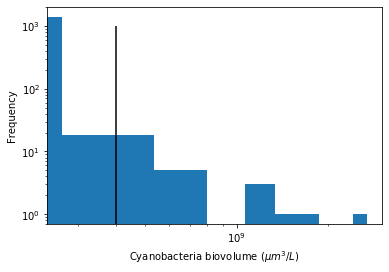

In [5]:
#Make a histogram to look at distribution of cyanobacteria biovolumes
plt.hist(ds1['NP_Cya_bio'], bins = 10)
plt.xscale('log')
plt.yscale('log')
plt.vlines(4e8, 0, 1e3)
plt.xlabel('Cyanobacteria biovolume ($\mu m^3/L$)')
plt.ylabel('Frequency')

In [6]:
#Create cleaned dataframe, ds2:
ds2 = ds1.drop(['StationID', 'Station', 'Date', 'Time', 'Stratum', 'Depth', 'target'], axis=1)

#Use regex to remove 'H's and 'J's
ds2['Month'] = ds1['Date'].astype(str).str.extract('(\d\d)').astype(int) # This is just the month number
ds2['TP'] = ds1['TP'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['DP'] = ds1['DP'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['Cl'] = ds1['Cl'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['TN'] = ds1['TN'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['TempC'] = ds1['TempC'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['Chla'] = ds1['Chla'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['Secchi'] = ds1['Secchi'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['N:P'] = ((ds2['TN']*1e-3)/14.007)/((ds2['TP']*1e-6)/30.974)
ds2['Target'] = [1 if x >= 4e8 else 0 for x in ds1['NP_Cya_bio']]

print(ds2[ds2['Target'] == 1])
#ds2
#type(ds2)

         TP    DP    Cl    TN  TempC    Chla  Secchi    NP_Cya_bio  Month  \
936    15.7   9.3  12.6  0.35   22.1   10.40     2.3  4.260000e+08      8   
940    17.9   NaN  12.3   NaN   20.2   10.30     1.5  5.250000e+08      9   
3037   37.0  12.1  10.6  0.74   24.7   28.20     1.1  7.110000e+08      8   
3038   41.7  13.5  10.9  0.61   20.5   25.38     1.3  7.280000e+08      8   
3269   75.5  23.2   6.7  0.64   17.3   36.00     1.1  4.230000e+08      9   
3271   69.4  33.6   7.3  0.63   13.0   12.60     1.3  7.050000e+08     10   
3307   66.4  16.6   5.9  0.74   21.3   44.90     1.0  1.260000e+09      8   
3400   40.2  16.0   7.7  0.80   23.8   45.03     1.5  1.170000e+09      7   
3461   62.9  18.0   6.3  0.77   19.3    3.73     1.2  4.380000e+08      9   
3464   73.7  19.5   6.6  0.80   17.3   42.40     0.8  1.540000e+09      9   
3499   74.1  29.7   7.1  0.81   23.2   45.50     1.1  1.190000e+09      8   
3556   61.4  20.0   6.0  0.55   23.5   31.80     1.5  5.190000e+08      8   

In [7]:
#Monthly Averages!
averages = ds2.groupby('Month').mean()
averages

#Now fill in the NaN's?
#months = [3,4,5,6,7,8,9,10,11]
#for month in months:
#    for column in ds2:
#        print(row)
        #if row[8] == month:
            #ds2.fillna(value = averages[month - 3, :], axis = 0)

#print(ds2[ds2['Target'] == 1])


,TP,DP,Cl,TN,TempC,Chla,Secchi,NP_Cya_bio,N:P,Target
Month,,,,,,,,,,
3,26.450000,11.500000,15.950000,0.465000,11.600000,5.720000,1.000000,0.000000e+00,38.584326,0.000000
4,21.214667,10.881333,11.652000,0.473600,6.494521,4.538667,3.477333,7.265987e+04,55.296756,0.000000
5,22.531064,11.357872,12.317447,0.455830,11.918894,5.714298,3.162232,1.660057e+05,53.629140,0.000000
6,23.720259,12.641202,12.016309,0.450515,18.219005,5.466121,3.533190,4.324034e+05,49.288794,0.000000
7,26.028685,13.642629,12.177689,0.410518,22.960811,7.444048,3.337698,2.784109e+07,43.321773,0.011765
8,28.241152,13.606996,12.318519,0.379132,22.830085,8.949256,3.409388,6.009197e+07,39.371036,0.040161
9,28.347887,14.217308,12.668545,0.378976,19.494898,8.943555,3.525116,3.985712e+07,40.393809,0.023148
10,28.346575,15.302759,12.795205,0.396164,14.613475,6.075479,3.842177,2.035035e+07,44.068551,0.013514
11,32.328571,19.550000,11.707143,0.492143,8.607143,3.741429,3.014286,3.575714e+05,43.012792,0.000000


In [146]:
#Drop cyanobac biovolumes - or not, depending what we're doing
#ds2 = ds2.drop(['NP_Cya_bio'], axis=1)

#Assign X and y
#X = np.array(ds2.drop(['Target'], axis=1))
#y = np.array(ds2['Target'])

#print((ds2))
#print(ds2[ds2['Target'] == 1])

#print(type(X))
#print(type(y))

In [147]:
#PCA!

#Drop all NAs:
ds2 = ds2.dropna(axis=0, how='any')

#Drop cyanobac biovolume and labels for X:
X = np.array(ds2.drop(['Target', 'NP_Cya_bio'], axis=1))
print(X.shape)

#PCA - never scale the data for PCA. And we don't need to center it because sklearn does this automatically.
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)

#Eigenvalues:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_)) 
#The first two components explain 90% of the variance!
#The first three components explain 94% of variance!


(1298, 9)
[0.75564308 0.14400889 0.0424884 ]
0.9421403715442513


Text(0, 0.5, 'X3')

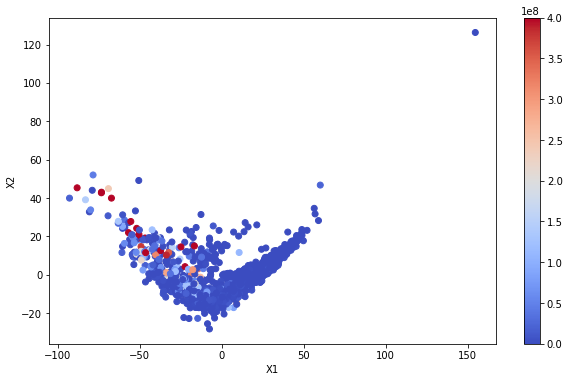

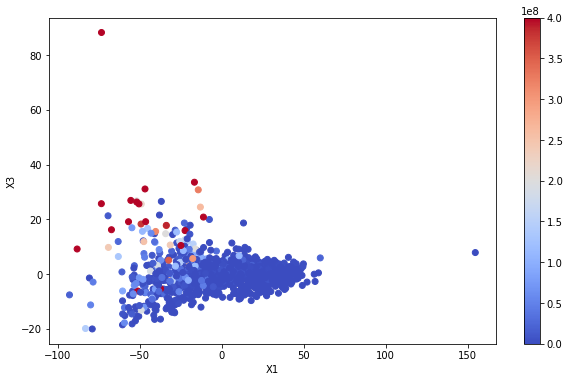

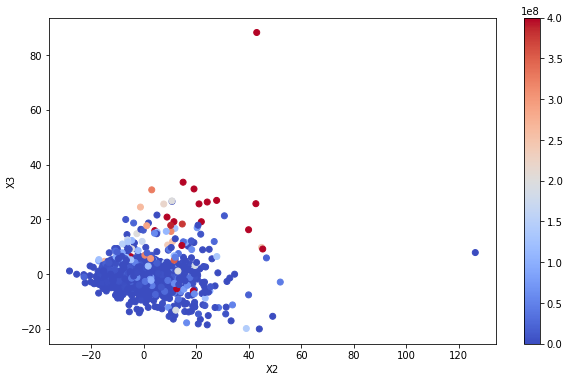

In [148]:
#2D Plots
#PC1 and 2
fig, ax = plt.subplots(figsize=(10,6))
scatter_plot = ax.scatter(X_pca[:,0], X_pca[:,1], c=np.array(ds2['NP_Cya_bio']), cmap=plt.cm.coolwarm, vmax = 4e8)
fig.colorbar(scatter_plot, ax=ax )
ax.set_xlabel('X1')
ax.set_ylabel('X2')

#PC1 and 3
fig2, ax2 = plt.subplots(figsize=(10,6))
scatter_plot2 = ax2.scatter(X_pca[:,0], X_pca[:,2], c=np.array(ds2['NP_Cya_bio']), cmap=plt.cm.coolwarm, vmax = 4e8)
fig.colorbar(scatter_plot2, ax=ax2 )
ax2.set_xlabel('X1')
ax2.set_ylabel('X3')

#PC2 and 3
fig3, ax3 = plt.subplots(figsize=(10,6))
scatter_plot3 = ax3.scatter(X_pca[:,1], X_pca[:,2], c=np.array(ds2['NP_Cya_bio']), cmap=plt.cm.coolwarm, vmax = 4e8)
fig.colorbar(scatter_plot3, ax=ax3 )
ax3.set_xlabel('X2')
ax3.set_ylabel('X3')

Text(0.5, 0, 'X3')

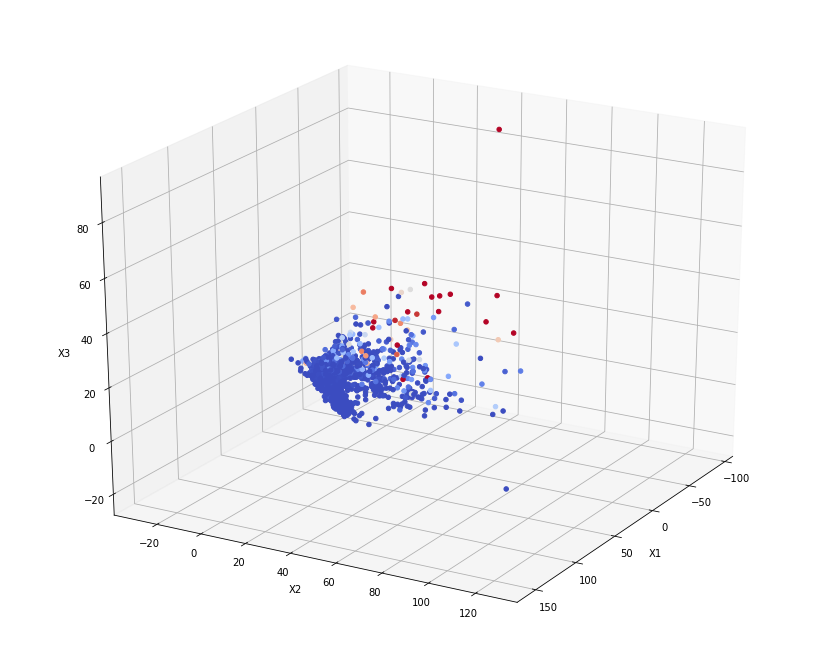

In [150]:
#3D Plot

fig4, ax4 = plt.subplots(figsize=(12, 9))
ax4 = Axes3D(fig4, rect=[0, 0, .95, 1], elev=24, azim=30)
#Change azi to rotate around the z axis, change elev to get a higher or lower angle
scatter_plot_3D = ax4.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=np.array(ds2['NP_Cya_bio']), cmap=plt.cm.coolwarm, vmax = 4e8, alpha = 1)
#fig.colorbar(scatter_plot_3D, ax=ax2, orientation = 'horizontal')
ax4.set_xlabel('X1')
ax4.set_ylabel('X2')
ax4.set_zlabel('X3')

#Interesting!